In [3]:
!git clone https://github.com/HoangVo-Prog/LTSF_Linear.git

Cloning into 'LTSF_Linear'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 102 (delta 47), reused 72 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 1.42 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (47/47), done.


### 1. Setup and basic load

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

# 1. Load data
df = pd.read_csv("LTSF_Linear/data/aio-2025-linear-forecasting-challenge/FPT_train.csv", parse_dates=["time"])
df = df.sort_values("time").reset_index(drop=True)

print(df.head())
print(df.dtypes)
print(df["time"].min(), df["time"].max(), len(df))


        time   open   high    low  close   volume symbol
0 2020-08-03  19.07  19.63  19.03  19.63  1392200    FPT
1 2020-08-04  19.89  20.01  19.76  19.91  1051310    FPT
2 2020-08-05  19.89  20.16  19.78  20.10  1328520    FPT
3 2020-08-06  20.10  20.21  19.97  20.01  1153660    FPT
4 2020-08-07  20.01  20.44  20.01  20.14  1283690    FPT
time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
symbol            object
dtype: object
2020-08-03 00:00:00 2025-03-10 00:00:00 1149


### 2. Price and volume over time

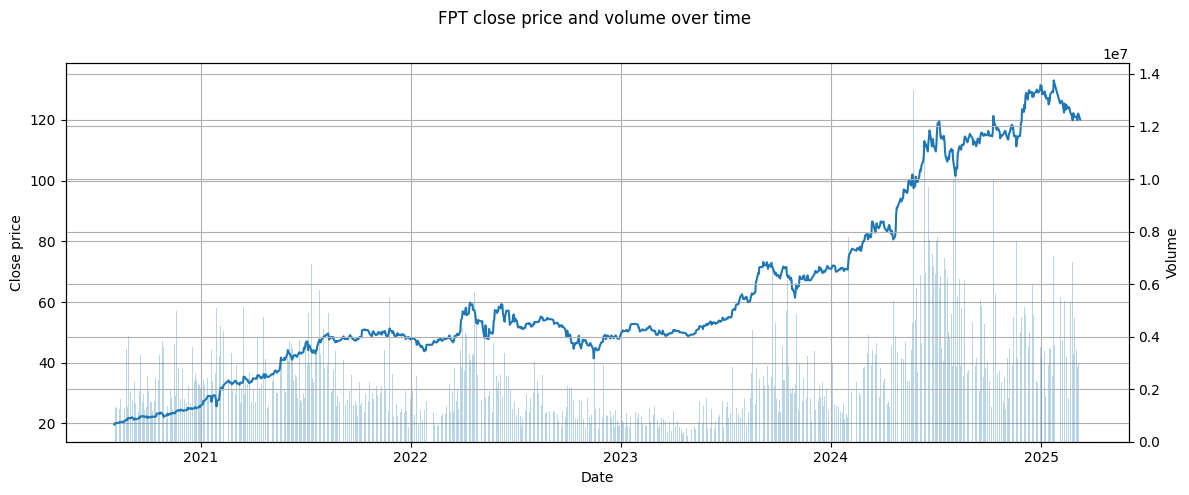

In [8]:
def plot_price_and_volume(df):
    fig, ax1 = plt.subplots()

    ax1.plot(df["time"], df["close"], label="Close price")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Close price")

    ax2 = ax1.twinx()
    ax2.bar(df["time"], df["volume"], alpha=0.3, label="Volume")
    ax2.set_ylabel("Volume")

    fig.suptitle("FPT close price and volume over time")
    fig.tight_layout()
    plt.show()

plot_price_and_volume(df)


### 3. Daily returns and volatility

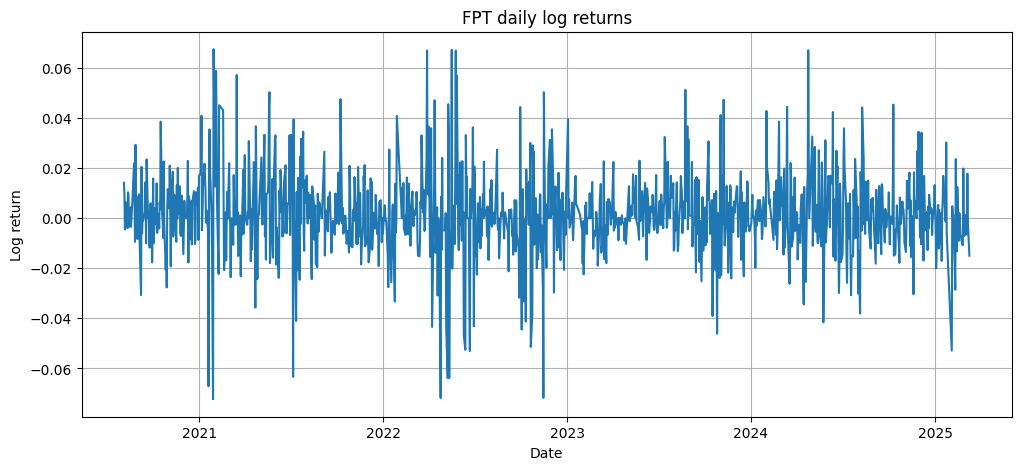

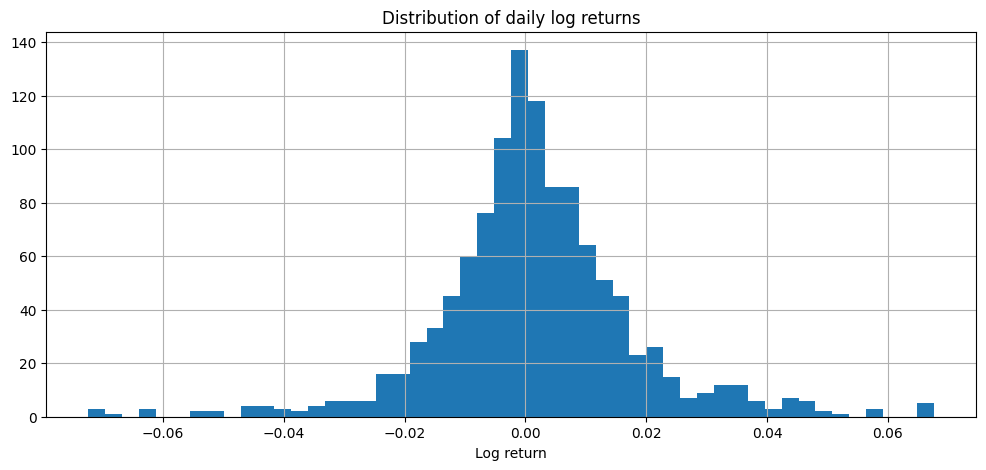

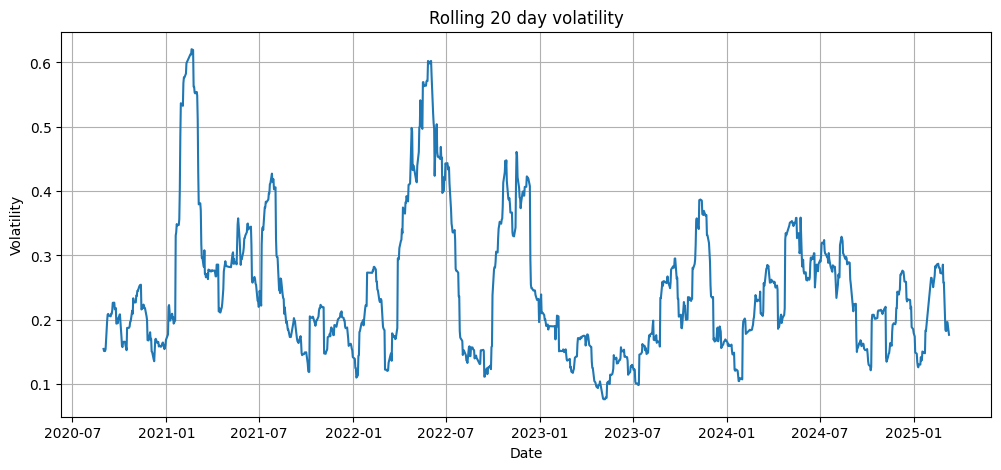

In [9]:
def add_return_features(df):
    df = df.copy()
    df["ret"] = df["close"].pct_change()
    df["log_ret"] = np.log(df["close"]).diff()
    df["ret_20d_vol"] = df["log_ret"].rolling(window=20).std() * np.sqrt(252)
    return df

df_feat = add_return_features(df)

def plot_returns(df):
    fig, ax = plt.subplots()
    ax.plot(df["time"], df["log_ret"], label="Daily log return")
    ax.set_xlabel("Date")
    ax.set_ylabel("Log return")
    ax.set_title("FPT daily log returns")
    plt.show()

    fig, ax = plt.subplots()
    ax.hist(df["log_ret"].dropna(), bins=50)
    ax.set_title("Distribution of daily log returns")
    ax.set_xlabel("Log return")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(df["time"], df["ret_20d_vol"], label="20 day realized vol (annualized)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.set_title("Rolling 20 day volatility")
    plt.show()

plot_returns(df_feat)


### 4. Train vs validation split visualization

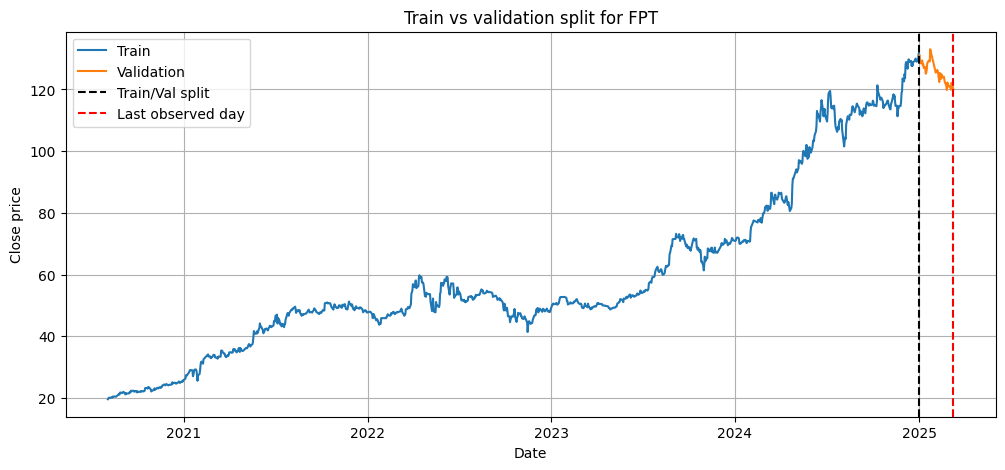

Last observed date: 2025-03-10 00:00:00
Target forecast period: next 100 days after this date


In [10]:
# Choose a split for validation
split_date = pd.Timestamp("2025-01-01")  # change if your config uses another date
last_date = df["time"].max()

def plot_train_val_split(df, split_date, last_date):
    fig, ax = plt.subplots()

    train_mask = df["time"] < split_date
    val_mask = df["time"] >= split_date

    ax.plot(df.loc[train_mask, "time"], df.loc[train_mask, "close"],
            label="Train", linewidth=1.5)
    ax.plot(df.loc[val_mask, "time"], df.loc[val_mask, "close"],
            label="Validation", linewidth=1.5)

    ax.axvline(split_date, color="black", linestyle="--", label="Train/Val split")
    ax.axvline(last_date, color="red", linestyle="--", label="Last observed day")

    ax.set_xlabel("Date")
    ax.set_ylabel("Close price")
    ax.set_title("Train vs validation split for FPT")
    ax.legend()
    plt.show()

plot_train_val_split(df, split_date, last_date)
print("Last observed date:", last_date)
print("Target forecast period: next 100 days after this date")


#### 5. Price vs volume scatter

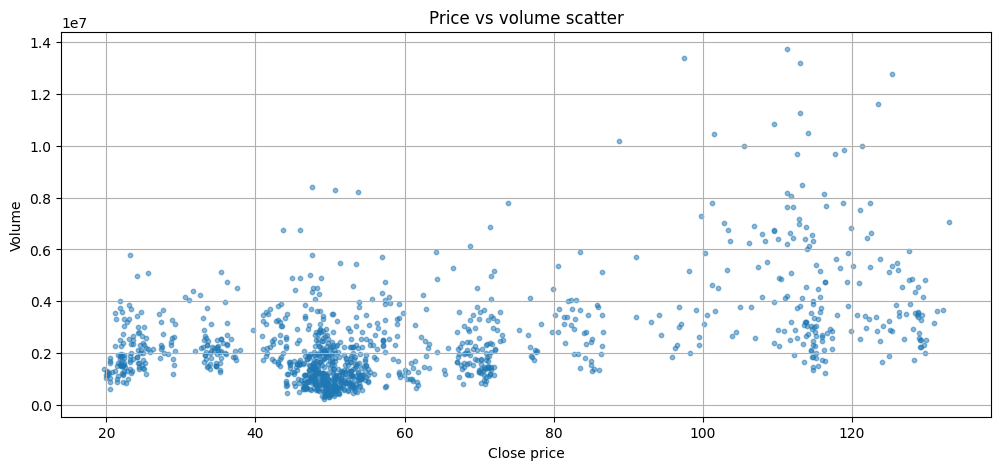

In [11]:
def plot_price_vs_volume(df):
    fig, ax = plt.subplots()
    ax.scatter(df["close"], df["volume"], s=10, alpha=0.5)
    ax.set_xlabel("Close price")
    ax.set_ylabel("Volume")
    ax.set_title("Price vs volume scatter")
    plt.show()

plot_price_vs_volume(df)


### Simple candlestick view

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.6 MB/s eta 0:00:00


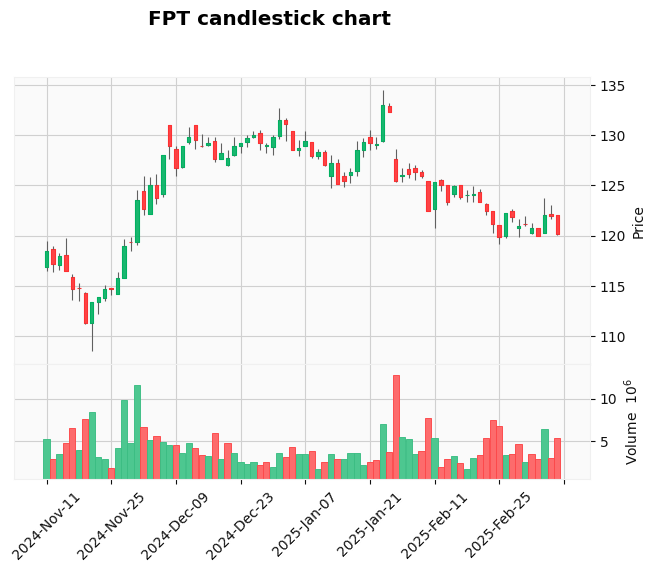

In [13]:
!pip install -q mplfinance
try:
    import mplfinance as mpf

    def plot_candles(df, start=None, end=None):
        data = df.set_index("time").copy()
        cols = ["open", "high", "low", "close", "volume"]
        data = data[cols]

        if start is not None:
            data = data.loc[data.index >= pd.to_datetime(start)]
        if end is not None:
            data = data.loc[data.index <= pd.to_datetime(end)]

        mpf.plot(
            data,
            type="candle",
            volume=True,
            title="FPT candlestick chart",
            style="yahoo",
        )

    # Example: last 120 days
    plot_candles(df, start=df["time"].max() - pd.Timedelta(days=120))

except ImportError:
    print("mplfinance is not installed. Run `pip install mplfinance` to enable candlestick plots.")
